<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2 Jan P. Siegel - Deep Learning

In [274]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

  Using cached https://files.pythonhosted.org/packages/ed/0e/5c61eedde9f6c87713e89d794f01e378cfd9565847d4576fa627d758c554/GPUtil-1.4.0.tar.gz
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=7989fc34f4d9de3875df323c8b5bcd82d84d68c13b9b02cda83394738a3354df
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [275]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

RAM Free: 11.3 GB  | Used: 4.1 GB
VRAM Free: 14041MB | Used: 1068MB | Util   7% Total 15109MB


##Parte 1


###Actividad 1

In [3]:
#deal with tensors
import torch   

#handling text data
from torchtext.legacy import data

#Reproducing same results
SEED = 2023

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
TEXT = data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

fields = [('text',TEXT), ('label', LABEL)]

#loading custom dataset
training_data = data.TabularDataset(path = "/content/drive/MyDrive/DL/T2/SMSSpamCollection.csv", format='csv', fields=fields, skip_header=True)

In [6]:
# print preprocessed text sample
print(vars(training_data.examples[0]))

{'text': ['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...'], 'label': '0'}


In [55]:
import random
train_data, valid_data, test_data = training_data.split(split_ratio=[70, 10, 20], random_state = random.seed(1334))
print("Train Data:", len(train_data))
print("Validation Data:", len(valid_data))
print("Test Data:", len(test_data))

Train Data: 3866
Validation Data: 1105
Test Data: 552


In [9]:
#initialize GloVe embeddings
TEXT.build_vocab(train_data,min_freq=5, vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
 99%|█████████▉| 397819/400000 [00:17<00:00, 23218.94it/s]

Size of TEXT vocabulary: 1629
Size of LABEL vocabulary: 2
[('.', 3382), ('to', 1469), ('I', 1404), ('you', 1305), (',', 1242), ('?', 1042), ('a', 908), ('!', 904), ('the', 825), ('...', 814)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f80dff6e0d0>>, {'<unk>': 0, '<pad>': 1, '.': 2, 'to': 3, 'I': 4, 'you': 5, ',': 6, '?': 7, 'a': 8, '!': 9, 'the': 10, '...': 11, 'i': 12, 'in': 13, 'and': 14, 'is': 15, 'me': 16, 'u': 17, '..': 18, 'for': 19, 'my': 20, 'it': 21, 'your': 22, 'of': 23, 'have': 24, 'that': 25, '&': 26, "'s": 27, 'on': 28, '2': 29, 'do': 30, 'are': 31, ' ': 32, 'call': 33, ';': 34, 'now': 35, ':': 36, "'m": 37, 'not': 38, 'with': 39, 'be': 40, 'at': 41, 'or': 42, 'will': 43, 'U': 44, "n't": 45, 'get': 46, 'nt': 47, 'can': 48, '*': 49, 'so': 50, 'You': 51, ')': 52, 'but': 53, 'ur': 54, 'up': 55, '£': 56, '-': 57, '4': 58, 'know': 59, 'we': 60, 'go': 61, 'like': 62, 'lt;#&gt': 63, 'from': 64, '"': 65, 'all': 66, 'out': 67, 'when': 

In [10]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
device = "cpu"
#set batch size
BATCH_SIZE = 8

#Load an iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

La idea de implementar un embedding para las palabras es poder pasar de datos en texto a tensores vectoriales numéricos, esto permite expresar las palabras en un formato que les añada riqueza en su descripción semántica (haciendo que palabras similares tengan valores cercanos) y además las haga consumibles por un modelo de aprendizaje automático.

En particular, GloVe no captura solamente las características estadísticas locales como Word2Vec, sino también las (Glo)bales para crear el (Ve)ctor deseado. Para lograr esto,  toma en cuenta relaciones semánticas locales, pero también deriva relaciones semánticas a partir de una matriz de co-ocurrencia, donde se indica qué tan probable es que una palabra aparezca en el contexto de otra. La gracia de GloVe es que puede expresar esta relación en un vector limpiamente con escasa pérdida de información.

###Actividad 2

In [11]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        self.bidirectional = bidirectional
        #Constructor
        super().__init__()          
        
        # embedding layer (GloVe)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # rnn layer
        self.rnn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        # dense layer 1
        if self.bidirectional:
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
          self.fc = nn.Linear(hidden_dim, 60)
        
        # dense layer 2
        self.act_intermediate = nn.ReLU()
        self.fc2 = nn.Linear(60, output_dim)
        
        # activation function
        # sigmoidal porque softmax da peores resultados
        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        #packed_output, (hidden, cell) = self.lstm(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        if self.bidirectional:
          #concat the final forward and backward hidden state
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)
        activated_outputs = self.act_intermediate(dense_outputs)
        dense_outputs2 = self.fc2(activated_outputs)
        #Final activation function
        outputs = self.act(dense_outputs2)
        
        return outputs

In [14]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)

In [15]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(1629, 100)
  (rnn): RNN(100, 80, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act_intermediate): ReLU()
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 182,381 trainable parameters
torch.Size([1629, 100])


El número de parámetros depende indirectamente del dataset utilizado, si usamos un dataset de texto muy grande y complejo, necesitaremos más dimensiones para obtener un buen embedding, lo que ser reflejará en la cantidad de parámetros de Wxh. Sin embargo, si se mantienen las dimensiones del embedding, la cantidad de parámetros no se verá afectada al cambiar de dataset.

Entonces, podemos ver que se puede reducir la cantidad de parámetros de la red cambiando el embedding usado, por ejemplo si usamos GloVe con 50d (en vez de 100d), tendremos un tensor de 50 dimensiones para capturar las features de cada palabra, en vez de 100 dimensiones para cada palabra. Esto reducirá la cantidad de parámetros entrenables en W_xh, todo lo anterior sin alterar la dimensionalidad de la capa oculta h_t.


In [16]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 120
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the new model
new_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(new_model)
print(f'The new model has {count_parameters(new_model):,} trainable parameters')

classifier(
  (embedding): Embedding(1629, 100)
  (rnn): RNN(100, 120, batch_first=True)
  (fc): Linear(in_features=120, out_features=60, bias=True)
  (act_intermediate): ReLU()
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act): Sigmoid()
)
The new model has 196,861 trainable parameters



Al pasar de 80 a 120 en la dimension de la capa oculta h_t, vemos que la cantidad de parámetros pasa de 182.381 a 196.861, es decir, un aumento de 14.480 parámetros lo que es explicable teniendo en cuenta que un aumento en h_t implica incrementar la cantidad de parámetros para todas las transformaciones del modelo, es decir, para W_hx, W_hh y W_yh. Esto sin duda tiene considerables implicancias en el tamaño paramétrico del modelo.

###Actividad 3

In [ ]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
print("curent device:", device)
model = model.to(device)
criterion = criterion.to(device)

In [18]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
            try:
              #retrieve text and no. of words
              text, text_lengths = batch.text
              
              #convert to 1d tensor
              predictions = model(text, text_lengths).squeeze()
              
              #compute loss and accuracy
              loss = criterion(predictions, batch.label)
              acc = binary_accuracy(predictions, batch.label)
              
              #keep track of loss and accuracy
              epoch_loss += loss.item()
              epoch_acc += acc.item()
            except Exception:
              pass
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [248]:
N_EPOCHS = 10
best_valid_loss = float('inf')

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.240 | Train Acc: 91.61%
	Val. Loss: 0.117 |  Val. Acc: 96.88%
Epoch: 2
	Train Loss: 0.099 | Train Acc: 97.16%
	Val. Loss: 0.102 |  Val. Acc: 96.51%
Epoch: 3
	Train Loss: 0.090 | Train Acc: 97.52%
	Val. Loss: 0.071 |  Val. Acc: 97.72%
Epoch: 4
	Train Loss: 0.054 | Train Acc: 98.73%
	Val. Loss: 0.070 |  Val. Acc: 97.60%
Epoch: 5
	Train Loss: 0.044 | Train Acc: 98.92%
	Val. Loss: 0.066 |  Val. Acc: 98.08%
Epoch: 6
	Train Loss: 0.037 | Train Acc: 99.12%
	Val. Loss: 0.094 |  Val. Acc: 97.12%
Epoch: 7
	Train Loss: 0.032 | Train Acc: 99.33%
	Val. Loss: 0.103 |  Val. Acc: 97.24%
Epoch: 8
	Train Loss: 0.032 | Train Acc: 99.20%
	Val. Loss: 0.066 |  Val. Acc: 98.02%
Epoch: 9
	Train Loss: 0.022 | Train Acc: 99.48%
	Val. Loss: 0.078 |  Val. Acc: 96.69%
Epoch: 10
	Train Loss: 0.033 | Train Acc: 99.33%
	Val. Loss: 0.081 |  Val. Acc: 98.08%


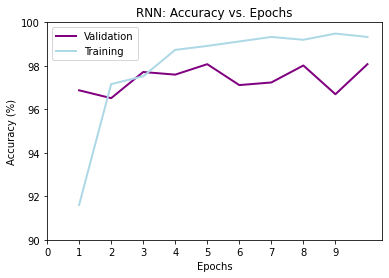

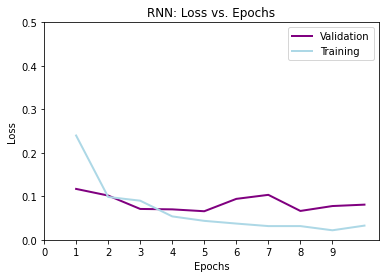

In [251]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,N_EPOCHS+1), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,N_EPOCHS+1), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.5))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

Podemos ver mediante los gráficos, que la configuración actual demuestra un rendimiento sobre el 98% para el set de entrenamiento y de validación, sin embargo, la pérdida del test de validación sube después de la época 5, mientras que la del test de entrenamiento sigue bajando, lo que indica un caso de overfitting.

In [272]:
_, test_accuracy = evaluate(model, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  97.64 %


De todas formas, vemos un rendimiento para el set de test de 97.64% , menos de un punto porcentual por debajo del test de validación, lo que demuestra que de todas formas se logró un alto poder de generalización para predecir si los mensajes de texto del dataset corresponden a *spamm* o no.

###Actividad 4

In [51]:
import torch.nn as nn

class classifier2(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        self.bidirectional = bidirectional
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        if self.bidirectional:
          self.fc = nn.Linear(hidden_dim * 2, 30)
        else:
          self.fc = nn.Linear(hidden_dim, 60)

        self.act0 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(30, output_dim)
        
        #activation function
        self.act1 = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        if self.bidirectional:
          #concat the final forward and backward hidden state
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        x = self.fc(hidden)
        x = self.act0(x)
        x = self.fc2(x)
        #Final activation function
        outputs=self.act1(x)
        
        return outputs

In [31]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the lstm model
lstm_model = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional=bidirection, dropout=dropout)
#architecture
print(lstm_model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(lstm_model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
lstm_model.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 100)
  (lstm): LSTM(100, 80, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 226,061 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3196, -0.0119,  0.0098,  ..., -0.0504,  0.2983,  1.3323],
        [ 0.5492,  0.1545, -0.6830,  ..., -1.2155,  0.5693,  1.0440],
        [-0.2009, -0.1691, -0.3587,  ..., -0.3249, -0.3411,  0.2473]])

In [32]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the lstm_model
    train_loss, train_acc = train(lstm_model, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the lstm_model
    valid_loss, valid_acc = evaluate(lstm_model, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.184 | Train Acc: 93.49%
	Val. Loss: 0.123 |  Val. Acc: 96.22%
Epoch: 2
	Train Loss: 0.064 | Train Acc: 98.04%
	Val. Loss: 0.055 |  Val. Acc: 97.66%
Epoch: 3
	Train Loss: 0.036 | Train Acc: 99.12%
	Val. Loss: 0.051 |  Val. Acc: 97.93%
Epoch: 4
	Train Loss: 0.031 | Train Acc: 99.10%
	Val. Loss: 0.053 |  Val. Acc: 97.93%
Epoch: 5
	Train Loss: 0.025 | Train Acc: 99.20%
	Val. Loss: 0.042 |  Val. Acc: 98.11%
Epoch: 6
	Train Loss: 0.013 | Train Acc: 99.69%
	Val. Loss: 0.045 |  Val. Acc: 98.11%
Epoch: 7
	Train Loss: 0.020 | Train Acc: 99.54%
	Val. Loss: 0.057 |  Val. Acc: 97.75%
Epoch: 8
	Train Loss: 0.012 | Train Acc: 99.72%
	Val. Loss: 0.056 |  Val. Acc: 97.84%
Epoch: 9
	Train Loss: 0.005 | Train Acc: 99.87%
	Val. Loss: 0.058 |  Val. Acc: 97.75%
Epoch: 10
	Train Loss: 0.003 | Train Acc: 99.90%
	Val. Loss: 0.066 |  Val. Acc: 98.02%


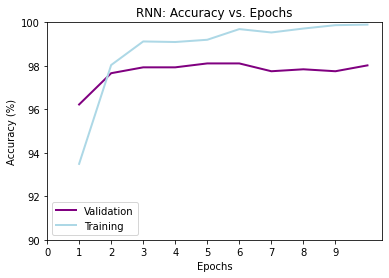

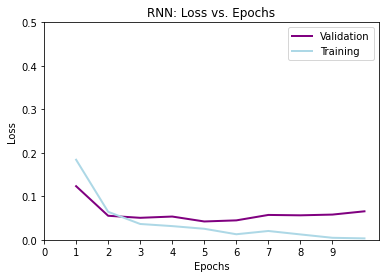

In [33]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,N_EPOCHS+1), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,N_EPOCHS+1), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.5))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

In [35]:
_, test_accuracy = evaluate(lstm_model, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  98.19 %


Al pasar a un modelo LSTM, el cual incorpora células de memoria para mantener de forma más robusta información tanto antigua como reciente, podemos observar un leve incremento en la precisión sobre el set de test, un 1% de mejoría respecto a la red recurrente tradicional para este set de datos particulares.
Esto podría explicarse porque las últimas palabras de los SMS efectivamente tienen suficiente información para determinar su clase (terminan con frecuencia en un precio o un numero al cual llamar), si bien mantener al tanto las palabras iniciales aporta información, no es crucial para esta tarea en particular.
Si bien vemos un aumento en el rendimiento, el modelo también es más pesado en su cantidad de parámetros, al necesitar algunos para mantener memoria de largo plazo. El LSTM usa 226 mil parámetros, un 24% más comparado con su RNN homóloga de 182 mil parámetros, lo cual por su puesto tambien se refleja en el tiempo de entrenamiento.

###Actividad 5

In [42]:
def train2(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 2
bidirection = False # set bidirection
dropout = 0

#instantiate the lstm model
deep_lstm = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(deep_lstm)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(deep_lstm):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
deep_lstm.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 100)
  (lstm): LSTM(100, 80, num_layers=2, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 277,901 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3196, -0.0119,  0.0098,  ..., -0.0504,  0.2983,  1.3323],
        [ 0.5492,  0.1545, -0.6830,  ..., -1.2155,  0.5693,  1.0440],
        [-0.2009, -0.1691, -0.3587,  ..., -0.3249, -0.3411,  0.2473]])

In [44]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(deep_lstm.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the deep_lstm
    train_loss, train_acc = train2(deep_lstm, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the deep_lstm
    valid_loss, valid_acc = evaluate(deep_lstm, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.177 | Train Acc: 93.60%
	Val. Loss: 0.108 |  Val. Acc: 96.67%
Epoch: 2
	Train Loss: 0.057 | Train Acc: 98.50%
	Val. Loss: 0.062 |  Val. Acc: 97.57%
Epoch: 3
	Train Loss: 0.039 | Train Acc: 98.99%
	Val. Loss: 0.042 |  Val. Acc: 98.02%
Epoch: 4
	Train Loss: 0.023 | Train Acc: 99.46%
	Val. Loss: 0.045 |  Val. Acc: 97.93%
Epoch: 5
	Train Loss: 0.027 | Train Acc: 99.35%
	Val. Loss: 0.056 |  Val. Acc: 96.94%
Epoch: 6
	Train Loss: 0.022 | Train Acc: 99.43%
	Val. Loss: 0.044 |  Val. Acc: 98.02%
Epoch: 7
	Train Loss: 0.017 | Train Acc: 99.51%
	Val. Loss: 0.045 |  Val. Acc: 98.20%
Epoch: 8
	Train Loss: 0.013 | Train Acc: 99.61%
	Val. Loss: 0.046 |  Val. Acc: 97.93%
Epoch: 9
	Train Loss: 0.004 | Train Acc: 99.90%
	Val. Loss: 0.056 |  Val. Acc: 98.02%
Epoch: 10
	Train Loss: 0.003 | Train Acc: 99.90%
	Val. Loss: 0.056 |  Val. Acc: 98.11%


Para el LSTM con 2 capas, hay tres aspectos que llaman la atención. En primer lugar, hay un notorio aumento en la cantidad de parámetros, llegando a 277 mil. Esto da paso al segundo aspecto, que es la velocidad de convergencia del entrenamiento, si bien es considerablemente más lento que los otros modelos (dado el aumento de parámetros), el modelo necesita algunas pocas épocas para mostrar resultados robustos. Finalmente, cabe destacar que no se ve una clara mejoría en la precisión del modelo, probablemente porque la tarea de clasificar mensajes de texto es suficientemente simple como para que baste una capa oculta para modelarlo con la complejidad necesaria.

In [ ]:
#GloVe embeddings with 50 dims instead of 100
TEXT.build_vocab(train_data,min_freq=5, vectors = "glove.6B.50d")  # changed to 50
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

In [63]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 50
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = True # set bidirection
dropout = 0

#instantiate the lstm model
bi_rnn = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(bi_rnn)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(bi_rnn):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
bi_rnn.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 50)
  (lstm): LSTM(50, 80, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=160, out_features=30, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 170,791 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 1.4680, -0.6181,  1.5910,  ...,  0.1525,  0.3721,  0.5773],
        [-0.2304, -0.0052, -1.4649,  ..., -1.1053, -0.7462,  0.2862],
        [ 0.0239, -0.3738, -0.1698,  ...,  0.0891,  0.3344, -0.4427]])

Finalmente para este último modelo tenemos un embedding de GloVe con 50 dimensiones (en vez de 100), una red recurrente bidireccional de 1 capa oculta, con un cambio en la dimension de su capa linear (de 60 a 30 dimensiones).

In [64]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(bi_rnn.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the bi_rnn
    train_loss, train_acc = train2(bi_rnn, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the bi_rnn
    valid_loss, valid_acc = evaluate(bi_rnn, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.185 | Train Acc: 93.16%
	Val. Loss: 0.103 |  Val. Acc: 95.59%
Epoch: 2
	Train Loss: 0.085 | Train Acc: 97.34%
	Val. Loss: 0.079 |  Val. Acc: 96.85%
Epoch: 3
	Train Loss: 0.057 | Train Acc: 98.19%
	Val. Loss: 0.063 |  Val. Acc: 97.12%
Epoch: 4
	Train Loss: 0.033 | Train Acc: 99.12%
	Val. Loss: 0.052 |  Val. Acc: 97.66%
Epoch: 5
	Train Loss: 0.030 | Train Acc: 99.23%
	Val. Loss: 0.049 |  Val. Acc: 97.93%
Epoch: 6
	Train Loss: 0.017 | Train Acc: 99.59%
	Val. Loss: 0.047 |  Val. Acc: 98.02%
Epoch: 7
	Train Loss: 0.013 | Train Acc: 99.61%
	Val. Loss: 0.052 |  Val. Acc: 97.93%
Epoch: 8
	Train Loss: 0.012 | Train Acc: 99.64%
	Val. Loss: 0.051 |  Val. Acc: 98.20%
Epoch: 9
	Train Loss: 0.013 | Train Acc: 99.69%
	Val. Loss: 0.041 |  Val. Acc: 98.38%
Epoch: 10
	Train Loss: 0.005 | Train Acc: 99.87%
	Val. Loss: 0.056 |  Val. Acc: 98.02%


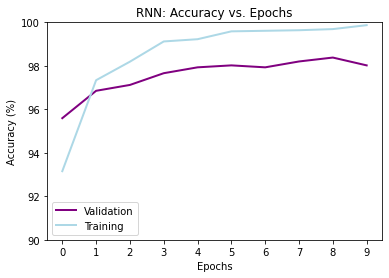

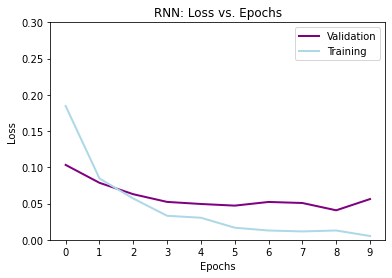

In [66]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(0,N_EPOCHS), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(0,N_EPOCHS), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(0,N_EPOCHS), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(0,N_EPOCHS), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.3))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

In [67]:
_, test_accuracy = evaluate(bi_rnn, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  98.19 %


Este último modelo presenta muy buenos resultados, llegando a una pérdida casi 0 en el set de test, y un 98% de precisión en set de validacion y de test. Si bien el número de parámetros disminuyó considerablemente (por la reducción de dimensiones a la mitad en el embedding), el tiempo de entrenamiento no fue menor a otros modelos, sin duda debido a la bidireccion, teniendo que pasar cada secuencia dos veces por la red.


##Referencias
https://www.kaggle.com/anindya2906/glove6b

https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html